# Finetune-ModenBert-For-Intent-Classification

The recent high-profile advances in LLMs have been in models like GPT, Llama, and Claude. Yet compact, task-specific models continue to play a vital role, especially for classification purposes when building practical and economical AI solutions. One key use case in modern applications is a Router Agent. A Router is a model that classifies user prompt ('intent') and forwards it to to the most appropriate Sub-Agent for handling. Smaller Models are very good fit for usecases where fast, accurate classification is essential.

I'll show you how to customize ModernBERT for classifying user queries to create a smart LLM routing system. As an enhanced iteration of BERT technology, ModernBERT offers expanded context capacity of 8192 tokens, superior performance on tasks, and enhanced processing efficiency.


**A Brief Look at ModernBERT**

ModernBERT represents a significant advancement in encoder model technology, offering full backwards compatibility while introducing several major architectural improvements over the original BERT. The model comes in two variations:

    ModernBERT Base (149M parameters)
    ModernBERT Large (395M parameters)

Key Technical Innovations:
- Rotary Positional Embeddings (RoPE) replace traditional positional encodings, enabling better understanding of word relationships and supporting longer sequences
- Alternating Attention patterns that combine global and local attention every 3 layers, significantly improving processing efficiency
- GeGLU layers replace traditional MLP layers, enhancing the original BERT's GeLU activation function
- Streamlined architecture with removed bias terms for more efficient parameter usage
- Additional normalization layer after embeddings for improved training stability
- Advanced sequence packing and unpadding techniques that reduce computational waste
- Hardware-optimized design that better aligns with modern GPU architectures

The model sets new performance standards in classification, retrieval, and code comprehension tasks, operating 2-4 times faster than previous encoders. This combination of speed and accuracy makes it ideal for high-volume production applications such as LLM routing, where both performance metrics are crucial.

What sets ModernBERT apart is its extensive training on 2 trillion tokens from diverse sources, including web content, programming code, and academic literature. This broad training foundation - significantly more varied than traditional BERT models' Wikipedia-centric approach - enables better understanding of user inputs across multiple domains. The model also features an impressive 8,192 token context length, which is 16 times larger than most existing encoders.

For detailed information about ModernBERT's architecture and development, you can find documentation on the [Hugging Face hub](https://huggingface.co/blog/modernbert).

In [3]:
# Install libraries
# %pip install torch==2.6.0
# %pip install -r requirements.txt
# %pip install -U sagemaker awscli -q 2>&1 | grep -v "warnings/venv"

In [4]:
import torch
torch.__version__

'2.7.1+cu126'

In [5]:

import logging
sagemaker_config_logger = logging.getLogger("sagemaker.config")
sagemaker_config_logger.setLevel(logging.WARNING)

# Import SageMaker SDK, setup our session
from sagemaker import get_execution_role, Session
from sagemaker.pytorch import PyTorch
import boto3

sess = Session(boto_session=boto3.Session())
default_bucket = sess.default_bucket()

print(sess.boto_region_name)
print(default_bucket)
print(get_execution_role())

us-east-2
sagemaker-us-east-2-207567795090
arn:aws:iam::207567795090:role/service-role/AmazonSageMaker-ExecutionRole-20250620T155960


# 1. Dataset Prep

## 1.1 Loading the training dataset

In [6]:
from datasets import load_dataset, DatasetDict
 
# Dataset id from huggingface.co/dataset
dataset_id = "bitext/Bitext-travel-llm-chatbot-training-dataset"
 
# Load raw dataset
raw_dataset = load_dataset(dataset_id)

raw_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'intent', 'category', 'tags', 'response'],
        num_rows: 31658
    })
})

## 1.2 Split Dataset into training and testing sets

In [7]:
# Schuffle dataset then split into train and test with 80:20 split
split_dataset = raw_dataset['train'].train_test_split(test_size=0.2, shuffle=True, seed=42)
    
# Create a new dataset dictionary with the splits
raw_dataset = DatasetDict({
    'train': split_dataset['train'],
    'test': split_dataset['test']
})


# Now you can use dataset['train'] and dataset['test']
print(f"Train set size: {len(raw_dataset['train'])}")
print(f"Test set size: {len(raw_dataset['test'])}")


Train set size: 25326
Test set size: 6332


In [8]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'intent', 'category', 'tags', 'response'],
        num_rows: 25326
    })
    test: Dataset({
        features: ['instruction', 'intent', 'category', 'tags', 'response'],
        num_rows: 6332
    })
})

## 1.3 Modify column names and remove non-required columns

In [9]:
# Function to modify the dataset
def modify_dataset(example):
    return {
        'text': example['instruction'],  # rename instruction to prompt
        'labels': example['category']
    }

# Apply the transformation to both train and test sets
filtered_dataset = raw_dataset.map(modify_dataset, 
                             remove_columns=['intent', 'instruction', 'category', 'tags', 'response'])

print("\nModified Dataset Structure:")
print(filtered_dataset)

Map:   0%|          | 0/25326 [00:00<?, ? examples/s]

Map:   0%|          | 0/6332 [00:00<?, ? examples/s]


Modified Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 25326
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 6332
    })
})


## 3.4 Inspect dataset

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to pandas DataFrames
train_df = pd.DataFrame(filtered_dataset['train'])
test_df = pd.DataFrame(filtered_dataset['test'])


train_df.head()

,text,labels
0,I want to know more about my flight insurance ...,FLIGHT
1,i want information about the cancellation char...,CANCELLATION_FEE
2,id like to check in by phone where could i do it,CHECK_IN
3,"I'm looking for a fucking travel insurance, he...",TRIP
4,could you help me getting my fucking boarding ...,BOARDING_PASS


## 3.5 Plot label distribution in train and test datasets

We notice from the plot below that train and test distributions are quite similar, which is good. However, we also notice a class imbalance where ~70% of the dataset queries are related to FLIGHT and TRIP topics. This is likely to have an adverse impact on the quality of our predictions if not taken into account during training. While in this notebook we will not account for the class imbalance, it's highly advised to check for class imbalance in your dataset and account for it in your loss function.See [here](https://discuss.huggingface.co/t/create-a-weighted-loss-function-to-handle-imbalance/138178) for inspiration.

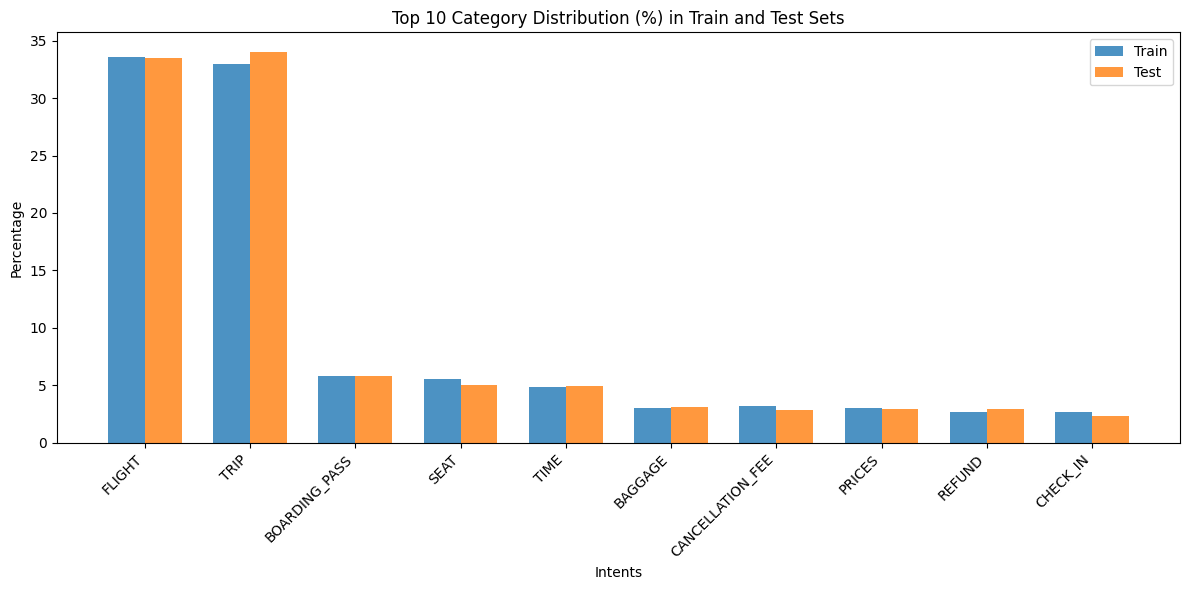

In [11]:
def plot_category_distribution(train_df, test_df, top_n=10):
    # Get category counts and calculate percentages
    train_total = len(train_df)
    test_total = len(test_df)
    train_pct = (train_df['labels'].value_counts() / train_total) * 100
    test_pct = (test_df['labels'].value_counts() / test_total) * 100

    # Combine percentages
    combined_pct = pd.DataFrame({
        'Train': train_pct,
        'Test': test_pct
    }).fillna(0)

    # Sort by total percentage and get top N categories
    combined_pct['Total'] = combined_pct['Train'] + combined_pct['Test']
    top_categories = combined_pct.nlargest(top_n, 'Total')

    # Create plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(top_categories))

    # Plot bars
    train_bars = plt.bar(index, top_categories['Train'], bar_width, label='Train', alpha=0.8)
    test_bars = plt.bar([i + bar_width for i in index], top_categories['Test'], bar_width, label='Test', alpha=0.8)

    plt.xlabel('Intents')
    plt.ylabel('Percentage')
    plt.title(f'Top {top_n} Category Distribution (%) in Train and Test Sets')
    plt.xticks([i + bar_width/2 for i in index], top_categories.index, rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage
plot_category_distribution(train_df, test_df, top_n=10)


## 3.6 Plot token counts in train and test datasets

Below, we will look at the number of tokens in our train and test data. This helps us understand the `max_seq_length` expected during training and inference. From the plot below, we see that the largest user prompt in both train and test sets had 36 tokens. This is far below the 8,192 token context length that ModernBERT can handle. If we do not specify the `max_model_length` parameter to our tokenizer, it will assume the worst-case scenario (8192) and will simply use a padding token to fill the remaining space. So even though the input sequence is at most 36 tokens, the tokenizer will pass a vector of size 8192 to the LLM (mostly filled with PAD tokens). This will consume excessive memory during training and inference.

To avoid excessive memory use, we will simply set our max context length `max_model_length` to 64. While this is 2x the expected tokens (to be on the safe side), it's still significantly lower than 8192. See section 2.2 where we actually set this hyperparameter.

[]

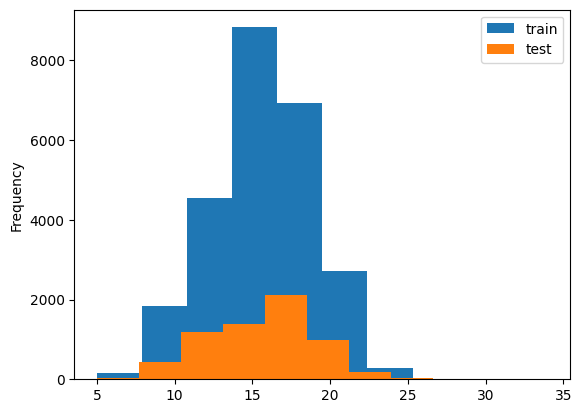

In [13]:
from transformers import AutoTokenizer

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def get_token_lengths(dataset):
    lengths = []
    for example in dataset['text']:
        tokens = tokenizer.encode(example)
        lengths.append(len(tokens))
    return lengths

pd.Series(get_token_lengths(train_df)).plot.hist(label="train")
pd.Series(get_token_lengths(test_df)).plot.hist(label="test")
plt.legend()
plt.plot()

## 3.5 Save dataset to s3

In [14]:
# Create full S3 paths
s3_path_train = f"s3://{default_bucket}/datasets/train"
s3_path_test = f"s3://{default_bucket}/datasets/test"

# Save dataset
filtered_dataset['train'].save_to_disk(s3_path_train)
filtered_dataset['test'].save_to_disk(s3_path_test)

print(s3_path_train, s3_path_test)

Saving the dataset (0/1 shards):   0%|          | 0/25326 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6332 [00:00<?, ? examples/s]

s3://sagemaker-us-east-2-207567795090/datasets/train s3://sagemaker-us-east-2-207567795090/datasets/test


# 2. Finetune the Model using train dataset

# 2.1 Create the training script

In [53]:
%pycat assets/train.py

import sys
import os
import random
import warnings
import argparse
from random import randrange
import os
import warnings
import random
import torch
import logging


import numpy as np
from sklearn.metrics import f1_score
from datasets import load_from_disk, Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AutoConfig,
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up logging
logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.getLevelName("INFO"),
    handlers=[logging.StreamHandler(sys.stdout)],
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

# Filter out the specific PyTorch warning about scalar tensors
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')


def set_random_seed(seed=42):
    ""

## 2.2 Define the training hyperpramaters

In [17]:
# hyperparameters which are passed to the training job
hyperparameters={
    'model_name': 'answerdotai/ModernBERT-base',
    'model_max_length': 64, #max sequence length in tokens
    'epochs': 2,
    'train_batch_size': 32,
    'eval_batch_size': 16,
    'warmup_steps': 500,
    'learning_rate': 5e-5,
    'dropout_rate': 0.3,
    'weight_decay': 0.2,
    'gradient_accumulation_steps': 2
}

## 2.3 Create sage Maker Estimator and fit it on the train and test data

In [23]:
from sagemaker.estimator import Estimator

# Define your image URI (example for PyTorch)
image_uri = "763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-training:2.7.1-gpu-py312-cu128-ubuntu22.04-sagemaker"

# Set up the estimator
estimator = Estimator(
    entry_point='train.py',
    source_dir='./assets',
    requirements_file='requirements.txt',  # Use this instead of dependencies
    image_uri=image_uri,
    role=get_execution_role(),
    instance_count=1,
    instance_type='ml.g5.xlarge',  # or your preferred instance type
    input_mode='File',
    output_path=f's3://{default_bucket}/training-output',
    base_job_name='Modernbert-training',
    keep_alive_period_in_seconds=1800,  # 30 minutes
    disable_profiler=True,
    debugger_hook_config=False,
    max_run=86400,  # 24 hours max run time
    sagemaker_session=sess,
    # Hyperparameters
    hyperparameters=hyperparameters,
)


In [25]:
estimator.fit(
  {'train': s3_path_train, 'test': s3_path_test}
)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: Modernbert-training-2025-08-04-16-24-04-240


2025-08-04 16:24:06 Starting - Starting the training job...
2025-08-04 16:24:19 Starting - Preparing the instances for training...
2025-08-04 16:25:06 Downloading - Downloading the training image.................................
2025-08-04 16:30:24 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
Skipping CUDA compat setup as package not found
2025-08-04 16:30:41,001 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-08-04 16:30:41,020 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-08-04 16:30:41,029 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-08-04 16:30:41,032 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-08-04 16:30:42,619 sagemaker-training-toolkit INFO     Installing dependenci

In [48]:
# s3 model artefacts
model_data = estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
model_data

's3://sagemaker-us-east-2-207567795090/training-output/Modernbert-training-2025-08-04-16-24-04-240/output/model.tar.gz'

# 3. Deploy the Model for Inference

## 3.1 Load model Artifacts from S3

In [50]:
import sagemaker
from sagemaker import Model
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


# model_data = 's3://sagemaker-us-east-2-207567795090/training-output/Modernbert-training-2025-06-27-20-07-05-940/output/model.tar.gz'
container = '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:2.6.0-gpu-py312-cu124-ubuntu22.04-sagemaker'

# Create model object
model = Model(
    entry_point="inference.py",
    source_dir="inference",
    model_data=model_data,
    image_uri=container,
    role=get_execution_role(),
    predictor_cls=None,
    env={
        'CHECKPOINT_SELECTION': 'latest',  # or 'specific' or 'best'
        'MODEL_CHECKPOINT': 'checkpoint-1188',  # used if CHECKPOINT_SELECTION='specific'
        # 'SAGEMAKER_MODEL_SERVER_TIMEOUT': '3600',
        # 'SAGEMAKER_MODEL_SERVER_WORKERS': '1'
    }
)




## 3.2 Create Realtime Endpoint

In [51]:
# Deploy the model to a GPU instance
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.g5.xlarge',  # GPU instance
    endpoint_name='modernBert-intentClassifier',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-2-207567795090/training-output/Modernbert-training-2025-08-04-16-24-04-240/output/model.tar.gz), script artifact (inference), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-2-207567795090/pytorch-inference-2025-08-04-16-48-55-920/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-08-04-16-53-30-116
INFO:sagemaker:Creating endpoint-config with name modernBert-intentClassifier
INFO:sagemaker:Creating endpoint with name modernBert-intentClassifier


-----------!

# 4 Make test predictions

In [55]:
# Make predictions
from sagemaker import Predictor

# Create predictor from endpoint
predictor = Predictor(
    endpoint_name='modernBert-intentClassifier',
    sagemaker_session=sess,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)



In [56]:
# Make prediction
prompt = "what time is my flight ?"
response = predictor.predict({'text': prompt})

print(response)

{'predicted_class': 'TIME', 'confidence': 0.9996291399002075}


In [57]:
# Make prediction
prompt = "where is the gate of my flight ?"
response = predictor.predict({'text': prompt})

print(response)

{'predicted_class': 'FLIGHT', 'confidence': 0.7404236793518066}


In [59]:
# Make prediction
prompt = "where can i store my bags ?"
response = predictor.predict({'text': prompt})

print(response)

{'predicted_class': 'BAGGAGE', 'confidence': 0.7879071831703186}


# 5 cleanup

In [ ]:
predictor.delete_endpoint()
predictor.delete_endpoint_config()
predictor.delete_model()